## COVID-19 data analysis
### Vaccination X Hospitalizations and deaths by covid in Rio Grande do Sul, Brazil

In [4]:
# For this analysis we will use 2 datasets:
# HOSPITALIZATION DATA WITH VACCINATION DATA
# POPULATION DATA

In [3]:
# Import the libraries and methods
import glob
import os
import pandas as pd

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from datetime import datetime as dt
from datetime import date
from datetime import timedelta
pd.set_option('mode.chained_assignment', None)


# Select specific columns to load from the dataset
cols = ['Data da Notificacao', 'Faixa Etaria', 'Idade', 'Evolucao', 'nm_regiao_covid', 
        'Classificacao final', 'v_dataaplicacao_dose_1', 'v_dataaplicacao_dose_2', 
        'v_dataaplicacao_dose_UNICA', 'v_nome_dose_1', 'v_nome_dose_2', 'v_nome_dose_UNICA',
        'data_aplic_ref']

# Read the dataset from a specified path
path = '../datasets/'
df_complete = pd.read_excel(path+'hospitalization_data.xlsx', usecols = cols)

In [131]:
df = df_complete.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155359 entries, 0 to 155358
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Data da Notificacao         155358 non-null  datetime64[ns]
 1   Idade                       155358 non-null  float64       
 2   Faixa Etaria                155358 non-null  object        
 3   Classificacao final         155358 non-null  object        
 4   Evolucao                    155358 non-null  object        
 5   nm_regiao_covid             155357 non-null  object        
 6   data_aplic_ref              18065 non-null   datetime64[ns]
 7   v_dataaplicacao_dose_1      91373 non-null   datetime64[ns]
 8   v_dataaplicacao_dose_2      80566 non-null   datetime64[ns]
 9   v_dataaplicacao_dose_UNICA  2227 non-null    datetime64[ns]
 10  v_nome_dose_1               91373 non-null   object        
 11  v_nome_dose_2               80566 non-n

In [132]:
# This dataset contains data from hospitalizations that occurred from respiratory illness. 
# We need to filter only COVID-19 confirmed cases
df = df[df['Classificacao final'] == 'COVID-19']

# Filter data from 2021
df = df[df['Data da Notificacao'] >= '2021-01-01']

# Insert Epidemiology Week number
df['SE'] = df['Data da Notificacao'].dt.strftime('2021_' + '%U')

In [133]:
# Create column with categories indicating 'fully_vaccinated' or 'vaccination_incomplete'
# Consider 'fully_vaccinated' when the person got a second dose shot or a one-shot vaccine
filtro_vacinado = (df['v_dataaplicacao_dose_2'].notna() | df['v_dataaplicacao_dose_UNICA'].notna())

df.loc[~filtro_vacinado, 'esquema_incompleto'] = 1 
df.loc[filtro_vacinado, 'vacinado'] = 1

In [134]:
# Filter period of 10 weeks (or 70 days) from the latest saturday (because we need complete epidemiology weeks)
last_saturday = pd.to_datetime(df['Data da Notificacao'][df['Data da Notificacao'].dt.dayofweek == 5].max())
first_day = (last_saturday - timedelta(days=69))

df = df[df['Data da Notificacao'].between(first_day, last_saturday)]

In [135]:
# Copy the dataframe to a new variable so we can use it later with different filters
df_vacinados = df.copy()

# Select only the columns of interest      
df = df[['Idade', 'Evolucao', 'nm_regiao_covid', 'SE', 'esquema_incompleto', 'vacinado']]

In [136]:
# Variable to inform the analyzed period in epidemiological weeks (for titles)
first_se = df['SE'].min()[5:]
last_se = df['SE'].max()[5:]

se_periodo = f'{first_se} a {last_se}'
se_periodo

'39 a 48'

## HOSPITALIZED PATIENTS DUE TO COVID-19

In [137]:
#### Individuals aged 60 and over #######
df_60anos_mais = df[df['Idade'] >= 60]
df_60anos_mais['hospitalizados'] = 1

df_60anos_mais = df_60anos_mais.pivot_table(values=['hospitalizados', 'esquema_incompleto', 'vacinado'], index=['nm_regiao_covid'], aggfunc='sum').reset_index()

df_60anos_mais = df_60anos_mais[['nm_regiao_covid', 'hospitalizados', 'esquema_incompleto', 'vacinado']]
cols = ['hospitalizados', 'esquema_incompleto', 'vacinado']
df_60anos_mais[cols] = df_60anos_mais[cols].astype(int)

# Row with Total
df_60anos_mais = df_60anos_mais.append(df_60anos_mais.sum(numeric_only=True), ignore_index=True).fillna('Total')

# Percentage of vaccination among hospitalized individuals
df_60anos_mais['%esquema_incompleto'] = ((df_60anos_mais['esquema_incompleto'] / df_60anos_mais['hospitalizados'])*100).round(2)
df_60anos_mais['%vacinado'] = ((df_60anos_mais['vacinado'] / df_60anos_mais['hospitalizados'])*100).round(2)

df_60anos_mais.rename(columns={'nm_regiao_covid': 'Região Covid', 'hospitalizados': 'Hospitalizados', 'esquema_incompleto': 'Esquema vacinal incompleto', 'vacinado': 'Vacinado', '%esquema_incompleto': '% Esquema vacinal incompleto', '%vacinado': '% Vacinado'}, inplace=True)
df_60anos_mais = df_60anos_mais[['Região Covid', 'Hospitalizados', 'Esquema vacinal incompleto',
                                 '% Esquema vacinal incompleto', 'Vacinado', '% Vacinado']]
date_today = date.today().strftime('%d_%m_%Y') 
#df_60anos_mais.to_excel(f'Hospitalizados e obitos x esquema vacinal/Hospitalizados por SRAG COVID-19 60mais anos x vacinação por região covid SE {se_periodo} gerado em {date_today}.xlsx', index=False)
#df_60anos_mais.to_csv(f'Hospitalizados e obitos x esquema vacinal/Hospitalizados por SRAG COVID-19 60mais anos x vacinação por região covid {date_today}.csv', index=False)

In [138]:
df_60anos_mais

,Região Covid,Hospitalizados,Esquema vacinal incompleto,% Esquema vacinal incompleto,Vacinado,% Vacinado
0,BAGE - R22,40.0,7.0,17.50,33.0,82.50
1,CACHOEIRA DO SUL - R27,28.0,3.0,10.71,25.0,89.29
2,CANOAS - R08,184.0,31.0,16.85,153.0,83.15
3,CAPAO DA CANOA - R04 R05,152.0,30.0,19.74,122.0,80.26
4,CAXIAS DO SUL - R23 R24 R25 R26,460.0,88.0,19.13,372.0,80.87
5,CRUZ ALTA - R12,29.0,4.0,13.79,25.0,86.21
6,ERECHIM - R16,32.0,7.0,21.88,25.0,78.12
7,GUAIBA - R09,74.0,12.0,16.22,62.0,83.78
8,IJUI - R13,86.0,17.0,19.77,69.0,80.23
9,LAJEADO - R29 R30,78.0,10.0,12.82,68.0,87.18


In [139]:
# Funtion for width of the figures
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

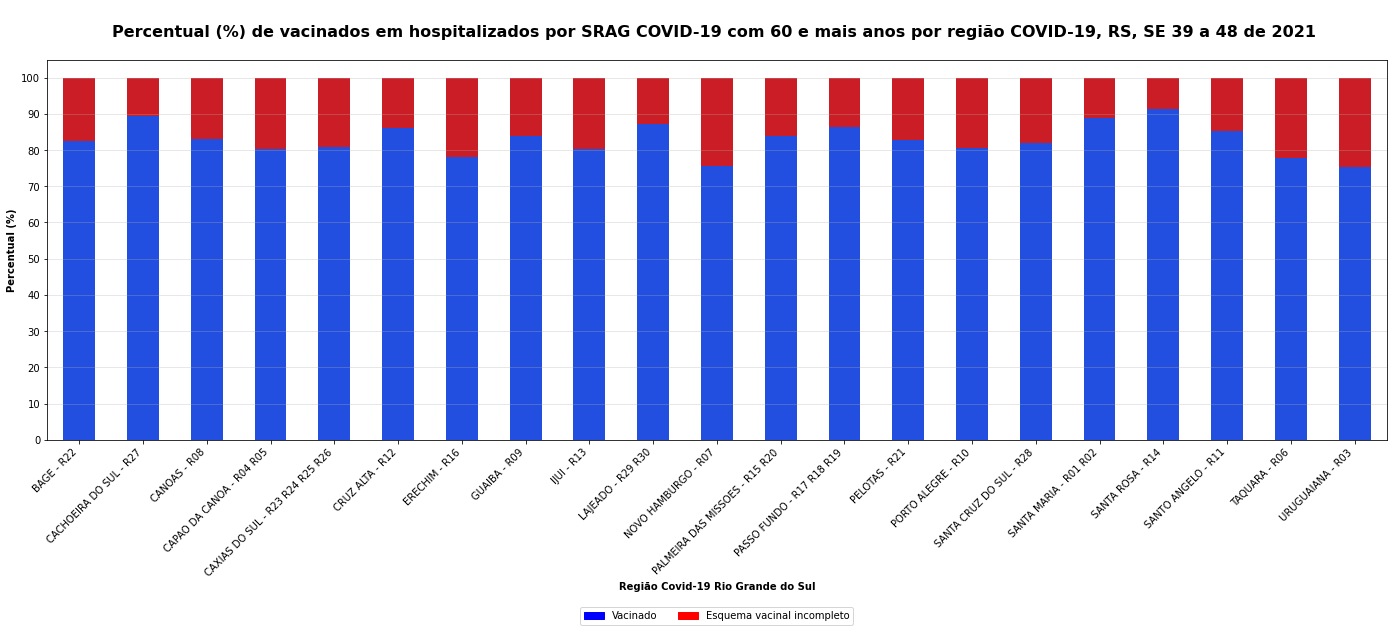

In [140]:
## Gráfico HOSPITALIZADOS 60 MAIS
# Hospitalizados por SRAG COVID-19 60mais anos x vacinação por região covid

df_60anos_mais_grafico = df_60anos_mais.loc[df_60anos_mais['Região Covid'] != 'Total']
df_60anos_mais_grafico['total'] = 100

fig, ax = plt.subplots(figsize=(24, 6))
colors = sns.color_palette("bright")
bar1 = sns.barplot(x="Região Covid",  y="total", data=df_60anos_mais_grafico, color=colors[3])
bar2 = sns.barplot(x="Região Covid", y="% Vacinado", data=df_60anos_mais_grafico, color=colors[0])

# add legend
top_bar = mpatches.Patch(color='red', label='Esquema vacinal incompleto')
bottom_bar = mpatches.Patch(color='blue', label='Vacinado')
plt.xticks(rotation=45, ha='right')
plt.legend(handles=[bottom_bar, top_bar], bbox_to_anchor=(0.5, -0.5), ncol=2, loc="lower center")
fig.subplots_adjust(bottom=0)
plt.title(f"\nPercentual (%) de vacinados em hospitalizados por SRAG COVID-19 com 60 e mais anos por região COVID-19, RS, SE {se_periodo} de 2021 \n",
         fontweight='bold', fontsize= 16)

plt.yticks(np.arange(0, 110, 10))
plt.grid(axis='y', linewidth=1, alpha=0.3)
change_width(ax, .5)

ax.set_xlabel('Região Covid-19 Rio Grande do Sul', fontweight='bold')
ax.set_ylabel('Percentual (%)', fontweight='bold')

#plt.savefig(f'Graficos/vacinados em hospitalizados por SRAG COVID-19 com 60 e mais anos por região COVID-19, RS, SE {se_periodo} de 2021 {date_today}.png', bbox_inches="tight")
plt.savefig(f'Grafico1 {se_periodo}.png', bbox_inches="tight")
plt.show()

In [141]:
#### 18 a 59 anos #######
filtro_18_a_59_anos = (df['Idade'] >= 18) & (df['Idade'] < 60)
df_18_a_59_anos = df[filtro_18_a_59_anos]

df_18_a_59_anos['hospitalizados'] = 1

df_18_a_59_anos = df_18_a_59_anos.pivot_table(values=['hospitalizados', 'esquema_incompleto', 'vacinado'], index=['nm_regiao_covid'], aggfunc='sum').reset_index()

df_18_a_59_anos = df_18_a_59_anos[['nm_regiao_covid', 'hospitalizados', 'esquema_incompleto', 'vacinado']]
cols = ['hospitalizados', 'esquema_incompleto', 'vacinado']
df_18_a_59_anos[cols] = df_18_a_59_anos[cols].astype(int)

# Insere linha com Total
df_18_a_59_anos = df_18_a_59_anos.append(df_18_a_59_anos.sum(numeric_only=True), ignore_index=True).fillna('Total')

# Percentuais de vacinação entre os hospitalizados
df_18_a_59_anos['%esquema_incompleto'] = ((df_18_a_59_anos['esquema_incompleto'] / df_18_a_59_anos['hospitalizados'])*100).round(2)
df_18_a_59_anos['%vacinado'] = ((df_18_a_59_anos['vacinado'] / df_18_a_59_anos['hospitalizados'])*100).round(2)

df_18_a_59_anos.rename(columns={'nm_regiao_covid': 'Região Covid', 'hospitalizados': 'Hospitalizados', 'esquema_incompleto': 'Esquema vacinal incompleto', 'vacinado': 'Vacinado', '%esquema_incompleto': '% Esquema vacinal incompleto', '%vacinado': '% Vacinado'}, inplace=True)
df_18_a_59_anos = df_18_a_59_anos[['Região Covid', 'Hospitalizados', 'Esquema vacinal incompleto',
                                 '% Esquema vacinal incompleto', 'Vacinado', '% Vacinado']]

#df_18_a_59_anos.to_excel(f'Hospitalizados e obitos x esquema vacinal/Hospitalizados por SRAG COVID-19 de 18 a 59 anos x vacinação por região covid SE {se_periodo} gerado em {date_today}.xlsx', index=False)

In [142]:
df_18_a_59_anos

,Região Covid,Hospitalizados,Esquema vacinal incompleto,% Esquema vacinal incompleto,Vacinado,% Vacinado
0,BAGE - R22,21.0,5.0,23.81,16.0,76.19
1,CACHOEIRA DO SUL - R27,12.0,4.0,33.33,8.0,66.67
2,CANOAS - R08,87.0,44.0,50.57,43.0,49.43
3,CAPAO DA CANOA - R04 R05,80.0,44.0,55.00,36.0,45.00
4,CAXIAS DO SUL - R23 R24 R25 R26,224.0,115.0,51.34,109.0,48.66
5,CRUZ ALTA - R12,10.0,1.0,10.00,9.0,90.00
6,ERECHIM - R16,21.0,11.0,52.38,10.0,47.62
7,GUAIBA - R09,27.0,12.0,44.44,15.0,55.56
8,IJUI - R13,48.0,19.0,39.58,29.0,60.42
9,LAJEADO - R29 R30,37.0,12.0,32.43,25.0,67.57


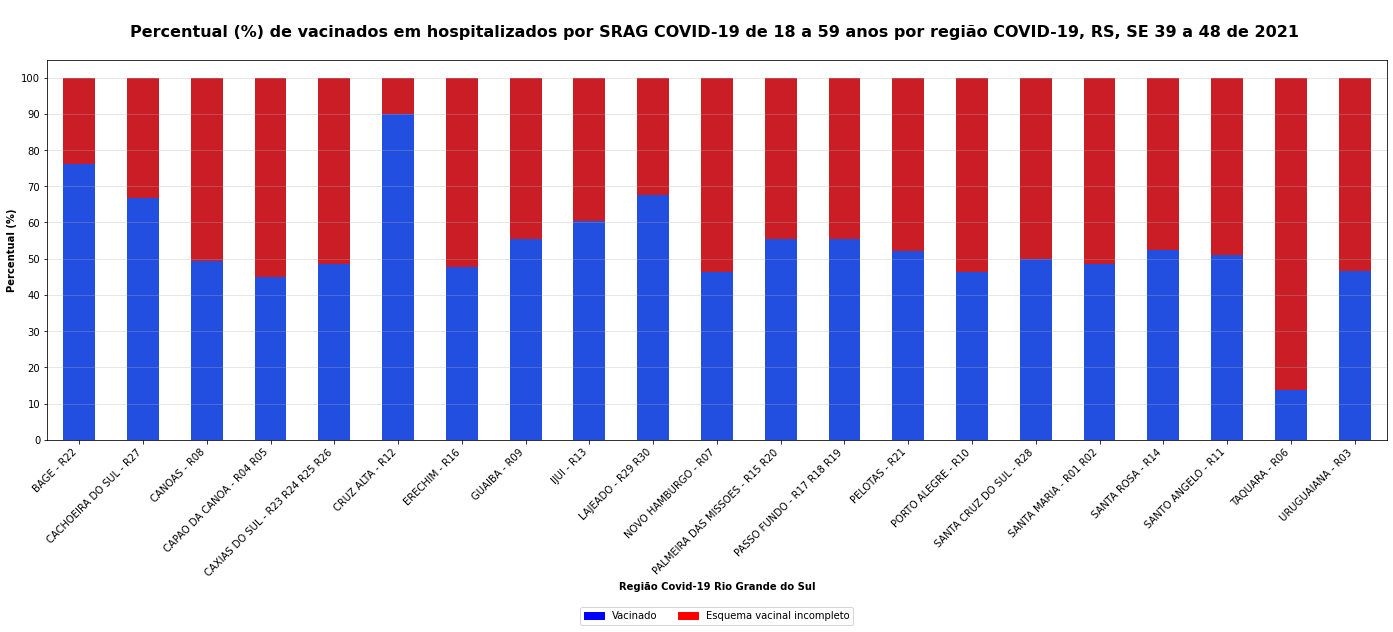

In [143]:
# GRAFICO ## HOSPITALIZADOS 18 - 59 ANOS ##

df_18_a_59_anos_grafico = df_18_a_59_anos.loc[df_18_a_59_anos['Região Covid'] != 'Total']
df_18_a_59_anos_grafico['total'] = 100

fig, ax = plt.subplots(figsize=(24, 6))
colors = sns.color_palette("bright")
bar1 = sns.barplot(x="Região Covid",  y="total", data=df_18_a_59_anos_grafico, color=colors[3])
bar2 = sns.barplot(x="Região Covid", y="% Vacinado", data=df_18_a_59_anos_grafico, color=colors[0])

# add legend
top_bar = mpatches.Patch(color='red', label='Esquema vacinal incompleto')
bottom_bar = mpatches.Patch(color='blue', label='Vacinado')
plt.xticks(rotation=45, ha='right')
plt.legend(handles=[bottom_bar, top_bar], bbox_to_anchor=(0.5, -0.5), ncol=2, loc="lower center")
fig.subplots_adjust(bottom=0)
plt.title(f"\nPercentual (%) de vacinados em hospitalizados por SRAG COVID-19 de 18 a 59 anos por região COVID-19, RS, SE {se_periodo} de 2021 \n",
         fontweight='bold', fontsize= 16)

plt.yticks(np.arange(0, 110, 10))
plt.grid(axis='y', linewidth=1, alpha=0.3)
change_width(ax, .5)

ax.set_xlabel('Região Covid-19 Rio Grande do Sul', fontweight='bold')
ax.set_ylabel('Percentual (%)', fontweight='bold')

#plt.savefig(f'Graficos/Vacinados em hospitalizados por SRAG COVID-19 de 18 a 59 anos por região COVID-19, RS, SE {se_periodo} de 2021.png', bbox_inches="tight")
plt.savefig(f'Grafico2 {se_periodo}.png', bbox_inches="tight")
plt.show()


# OBITOS

In [144]:
#### OBITOS #####

#### MAIORES DE 60 anos #######
obitos_60anos_mais = df[df['Idade'] >= 60]
obitos_60anos_mais = obitos_60anos_mais[obitos_60anos_mais['Evolucao'] == 'Óbito']
obitos_60anos_mais['Óbitos'] = 1

obitos_60anos_mais = obitos_60anos_mais.pivot_table(values=['Óbitos', 'esquema_incompleto', 'vacinado'], index=['nm_regiao_covid'], aggfunc='sum').reset_index()

obitos_60anos_mais = obitos_60anos_mais[['nm_regiao_covid', 'Óbitos', 'esquema_incompleto', 'vacinado']]
cols = ['Óbitos', 'esquema_incompleto', 'vacinado']
obitos_60anos_mais[cols] = obitos_60anos_mais[cols].astype(int)

# Insere linha com Total
obitos_60anos_mais = obitos_60anos_mais.append(obitos_60anos_mais.sum(numeric_only=True), ignore_index=True).fillna('Total')

# Percentuais de vacinação entre os Óbitos
obitos_60anos_mais['%esquema_incompleto'] = ((obitos_60anos_mais['esquema_incompleto'] / obitos_60anos_mais['Óbitos'])*100).round(2)
obitos_60anos_mais['%vacinado'] = ((obitos_60anos_mais['vacinado'] / obitos_60anos_mais['Óbitos'])*100).round(2)

obitos_60anos_mais.rename(columns={'nm_regiao_covid': 'Região Covid', 'esquema_incompleto': 'Esquema vacinal incompleto', 'vacinado': 'Vacinado', '%esquema_incompleto': '% Esquema vacinal incompleto', '%vacinado': '% Vacinado'}, inplace=True)

obitos_60anos_mais = obitos_60anos_mais[['Região Covid', 'Óbitos', 'Esquema vacinal incompleto',
                                 '% Esquema vacinal incompleto', 'Vacinado', '% Vacinado']]

#obitos_60anos_mais.to_excel(f'Hospitalizados e obitos x esquema vacinal/Óbitos por SRAG COVID-19 60 e mais anos x vacinação por região covid SE {se_periodo} de 2021 gerado em {date_today}.xlsx', index=False)

In [145]:
obitos_60anos_mais

,Região Covid,Óbitos,Esquema vacinal incompleto,% Esquema vacinal incompleto,Vacinado,% Vacinado
0,BAGE - R22,9.0,4.0,44.44,5.0,55.56
1,CACHOEIRA DO SUL - R27,13.0,2.0,15.38,11.0,84.62
2,CANOAS - R08,88.0,17.0,19.32,71.0,80.68
3,CAPAO DA CANOA - R04 R05,52.0,12.0,23.08,40.0,76.92
4,CAXIAS DO SUL - R23 R24 R25 R26,126.0,28.0,22.22,98.0,77.78
5,CRUZ ALTA - R12,19.0,1.0,5.26,18.0,94.74
6,ERECHIM - R16,4.0,3.0,75.00,1.0,25.00
7,GUAIBA - R09,30.0,5.0,16.67,25.0,83.33
8,IJUI - R13,19.0,3.0,15.79,16.0,84.21
9,LAJEADO - R29 R30,23.0,4.0,17.39,19.0,82.61


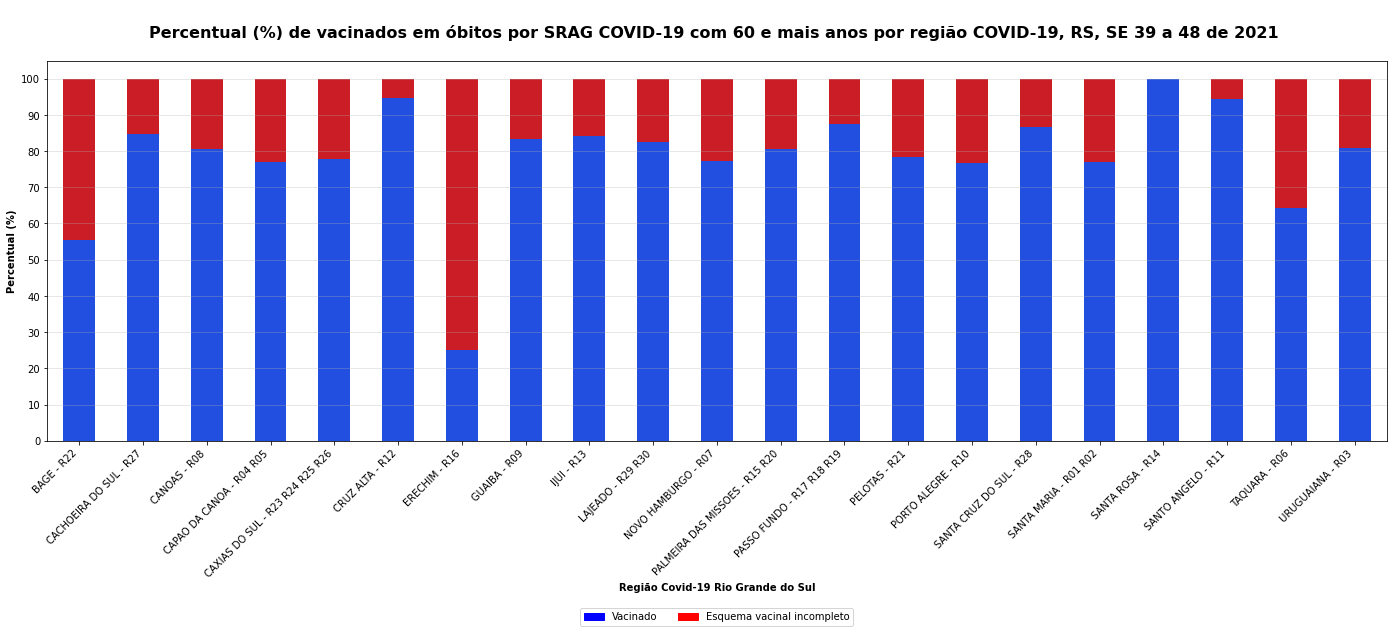

In [146]:
## ÓBITOS 60 MAIS ANOS ##

obitos_60anos_mais_grafico = obitos_60anos_mais.loc[obitos_60anos_mais['Região Covid'] != 'Total']
obitos_60anos_mais_grafico['total'] = 100

fig, ax = plt.subplots(figsize=(24, 6))
colors = sns.color_palette("bright")
bar1 = sns.barplot(x="Região Covid",  y="total", data=obitos_60anos_mais_grafico, color=colors[3])
bar2 = sns.barplot(x="Região Covid", y="% Vacinado", data=obitos_60anos_mais_grafico, color=colors[0])

# add legend
top_bar = mpatches.Patch(color='red', label='Esquema vacinal incompleto')
bottom_bar = mpatches.Patch(color='blue', label='Vacinado')
plt.xticks(rotation=45, ha='right')
plt.legend(handles=[bottom_bar, top_bar], bbox_to_anchor=(0.5, -0.5), ncol=2, loc="lower center")
fig.subplots_adjust(bottom=0)
plt.title(f"\nPercentual (%) de vacinados em óbitos por SRAG COVID-19 com 60 e mais anos por região COVID-19, RS, SE {se_periodo} de 2021 \n",
         fontweight='bold', fontsize= 16)

plt.yticks(np.arange(0, 110, 10))
plt.grid(axis='y', linewidth=1, alpha=0.3)
change_width(ax, .5)

ax.set_xlabel('Região Covid-19 Rio Grande do Sul', fontweight='bold')
ax.set_ylabel('Percentual (%)', fontweight='bold')

#plt.savefig(f'Graficos/Vacinados em óbitos por SRAG COVID-19 com 60 e mais anos por região COVID-19, RS, SE {se_periodo} de 2021.png', bbox_inches="tight")

plt.savefig(f'Grafico3 {se_periodo}.png', bbox_inches="tight")

plt.show()

In [147]:
## OBITOS ###
#### 18 a 59 anos #######
filtro_18_a_59_anos = (df['Idade'] >= 18) & (df['Idade'] < 60)
obito_18_a_59_anos = df[filtro_18_a_59_anos]

obito_18_a_59_anos = obito_18_a_59_anos[obito_18_a_59_anos['Evolucao'] == 'Óbito']

obito_18_a_59_anos['Óbitos'] = 1

obito_18_a_59_anos = obito_18_a_59_anos.pivot_table(values=['Óbitos', 'esquema_incompleto', 'vacinado'], index=['nm_regiao_covid'], aggfunc='sum').reset_index()

obito_18_a_59_anos = obito_18_a_59_anos[['nm_regiao_covid', 'Óbitos', 'esquema_incompleto', 'vacinado']]
cols = ['Óbitos', 'esquema_incompleto', 'vacinado']
obito_18_a_59_anos[cols] = obito_18_a_59_anos[cols].astype(int)

# Insere linha com Total
obito_18_a_59_anos = obito_18_a_59_anos.append(obito_18_a_59_anos.sum(numeric_only=True), ignore_index=True).fillna('Total')

# Percentuais de vacinação entre os obitos
obito_18_a_59_anos['%esquema_incompleto'] = ((obito_18_a_59_anos['esquema_incompleto'] / obito_18_a_59_anos['Óbitos'])*100).round(2)
obito_18_a_59_anos['%vacinado'] = ((obito_18_a_59_anos['vacinado'] / obito_18_a_59_anos['Óbitos'])*100).round(2)

obito_18_a_59_anos.rename(columns={'nm_regiao_covid': 'Região Covid', 'esquema_incompleto': 'Esquema vacinal incompleto', 'vacinado': 'Vacinado', '%esquema_incompleto': '% Esquema vacinal incompleto', '%vacinado': '% Vacinado'}, inplace=True)

obito_18_a_59_anos = obito_18_a_59_anos[['Região Covid', 'Óbitos', 'Esquema vacinal incompleto',
                                 '% Esquema vacinal incompleto', 'Vacinado', '% Vacinado']]

#obito_18_a_59_anos.to_excel(f'Hospitalizados e obitos x esquema vacinal/Óbitos por SRAG COVID-19 de 18 a 59 anos x vacinação por região covid SE {se_periodo} de 2021 gerado em {date_today}.xlsx', index=False)

In [148]:
obito_18_a_59_anos

,Região Covid,Óbitos,Esquema vacinal incompleto,% Esquema vacinal incompleto,Vacinado,% Vacinado
0,BAGE - R22,2.0,0.0,0.00,2.0,100.00
1,CACHOEIRA DO SUL - R27,1.0,1.0,100.00,0.0,0.00
2,CANOAS - R08,23.0,13.0,56.52,10.0,43.48
3,CAPAO DA CANOA - R04 R05,13.0,7.0,53.85,6.0,46.15
4,CAXIAS DO SUL - R23 R24 R25 R26,27.0,15.0,55.56,12.0,44.44
5,CRUZ ALTA - R12,3.0,0.0,0.00,3.0,100.00
6,ERECHIM - R16,2.0,2.0,100.00,0.0,0.00
7,GUAIBA - R09,6.0,2.0,33.33,4.0,66.67
8,IJUI - R13,2.0,2.0,100.00,0.0,0.00
9,LAJEADO - R29 R30,4.0,1.0,25.00,3.0,75.00


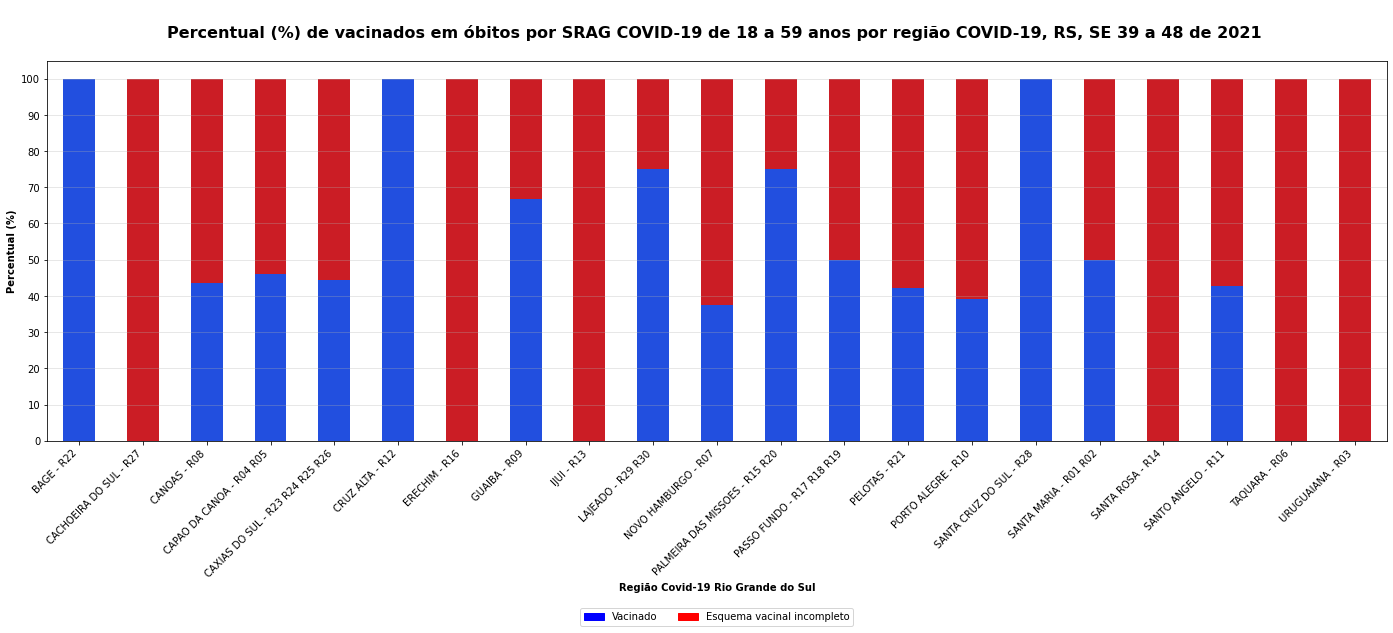

In [149]:
## GRAFICO ÓBITOS 18 - 59 ANOS ##

obito_18_a_59_anos_grafico = obito_18_a_59_anos.loc[obito_18_a_59_anos['Região Covid'] != 'Total']
obito_18_a_59_anos_grafico['total'] = 100

fig, ax = plt.subplots(figsize=(24, 6))
colors = sns.color_palette("bright")
bar1 = sns.barplot(x="Região Covid",  y="total", data=obito_18_a_59_anos_grafico, color=colors[3])
bar2 = sns.barplot(x="Região Covid", y="% Vacinado", data=obito_18_a_59_anos_grafico, color=colors[0])

# add legend
top_bar = mpatches.Patch(color='red', label='Esquema vacinal incompleto')
bottom_bar = mpatches.Patch(color='blue', label='Vacinado')
plt.xticks(rotation=45, ha='right')
plt.legend(handles=[bottom_bar, top_bar], bbox_to_anchor=(0.5, -0.5), ncol=2, loc="lower center")
fig.subplots_adjust(bottom=0)
plt.title(f"\nPercentual (%) de vacinados em óbitos por SRAG COVID-19 de 18 a 59 anos por região COVID-19, RS, SE {se_periodo} de 2021 \n",
         fontweight='bold', fontsize= 16)

plt.yticks(np.arange(0, 110, 10))
plt.grid(axis='y', linewidth=1, alpha=0.3)
change_width(ax, .5)

ax.set_xlabel('Região Covid-19 Rio Grande do Sul', fontweight='bold')
ax.set_ylabel('Percentual (%)', fontweight='bold')

#plt.savefig(f'Graficos/Vacinados em óbitos por SRAG COVID-19 de 18 a 59 anos por região COVID-19, RS, SE {se_periodo} de 2021.png', bbox_inches="tight")

plt.savefig(f'Grafico4 {se_periodo}.png', bbox_inches="tight")

plt.show()

In [150]:
''' 
TANI - tabela com todo o RS (não separar por regiões)
cada linha com uma faixa etária - como no painel vacina
mesmas info dos graficos já gerados só que todo o RS
% vacinados por faixa etária (usar como o painel)
12 - 17
18 - 29
30 - 39
40 - 49
50 - 59
60 - 69
70 - 79
80 e mais
alterar ordem das colunas da tabela - esquema vacinal e %'''

' \nTANI - tabela com todo o RS (não separar por regiões)\ncada linha com uma faixa etária - como no painel vacina\nmesmas info dos graficos já gerados só que todo o RS\n% vacinados por faixa etária (usar como o painel)\n12 - 17\n18 - 29\n30 - 39\n40 - 49\n50 - 59\n60 - 69\n70 - 79\n80 e mais\nalterar ordem das colunas da tabela - esquema vacinal e %'

In [151]:
#### FAIXAS ETARIAS x STATUS VACINAL x HOSPITALIZAÇÕES #######
df_faixas = df_vacinados[['Idade', 'Faixa Etaria', 'Evolucao', 'SE', 'esquema_incompleto', 'vacinado']]

df_faixas['Idade'] = df_faixas['Idade'].astype(int)
df_faixas = df_faixas[df_faixas['Idade'] >= 12]
df_faixas.loc[((df_faixas['Idade'] >= 12) & (df_faixas['Idade'] <= 17)), 'Faixa Etaria'] = '12-17'
df_faixas.loc[((df_faixas['Idade'] >= 18) & (df_faixas['Idade'] <= 29)), 'Faixa Etaria'] = '18-29'
df_faixas['Faixa Etaria'] = df_faixas['Faixa Etaria'].str.replace(' anos', '')
df_faixas.loc[df_faixas['Faixa Etaria'].str.contains('80 e mais'), 'Faixa Etaria'] = '80+'
df_faixas.drop(columns=['Idade'], axis=1, inplace=True)

df_faixas['hospitalizados'] = 1

df_faixas = df_faixas.pivot_table(values=['hospitalizados', 'esquema_incompleto', 'vacinado'], index=['Faixa Etaria'], aggfunc='sum').reset_index()

# Insere linha com Total
df_faixas = df_faixas.append(df_faixas.sum(numeric_only=True), ignore_index=True).fillna('Total')

# Percentuais de vacinação entre os hospitalizados
df_faixas['%esquema_incompleto'] = ((df_faixas['esquema_incompleto'] / df_faixas['hospitalizados'])*100).round(2)
df_faixas['%vacinado'] = ((df_faixas['vacinado'] / df_faixas['hospitalizados'])*100).round(2)

cols = ['hospitalizados', 'esquema_incompleto', 'vacinado']
df_faixas[cols] = df_faixas[cols].astype(int)

df_faixas.rename(columns={'Faixa Etaria': 'Faixa Etária', 'hospitalizados': 'Hospitalizados', 'esquema_incompleto': 'Esquema vacinal incompleto', 'vacinado': 'Vacinado', '%esquema_incompleto': '% Esquema vacinal incompleto', '%vacinado': '% Vacinado'}, inplace=True)

df_faixas = df_faixas[['Faixa Etária', 'Hospitalizados', 'Esquema vacinal incompleto', 
                       '% Esquema vacinal incompleto', 'Vacinado','% Vacinado']]

#df_faixas.to_excel(f'Hospitalizados e obitos x esquema vacinal/Status vacinal x Hospitalizados por SRAG COVID-19 por faixa etária no RS SE {se_periodo} gerado em {date_today}.xlsx', index=False)

df_faixas

,Faixa Etária,Hospitalizados,Esquema vacinal incompleto,% Esquema vacinal incompleto,Vacinado,% Vacinado
0,12-17,14,12,85.71,2,14.29
1,18-29,125,73,58.40,52,41.60
2,30-39,259,155,59.85,104,40.15
3,40-49,372,181,48.66,191,51.34
4,50-59,477,204,42.77,273,57.23
5,60-69,1059,242,22.85,817,77.15
6,70-79,1117,171,15.31,946,84.69
7,80+,608,97,15.95,511,84.05
8,Total,4031,1135,28.16,2896,71.84


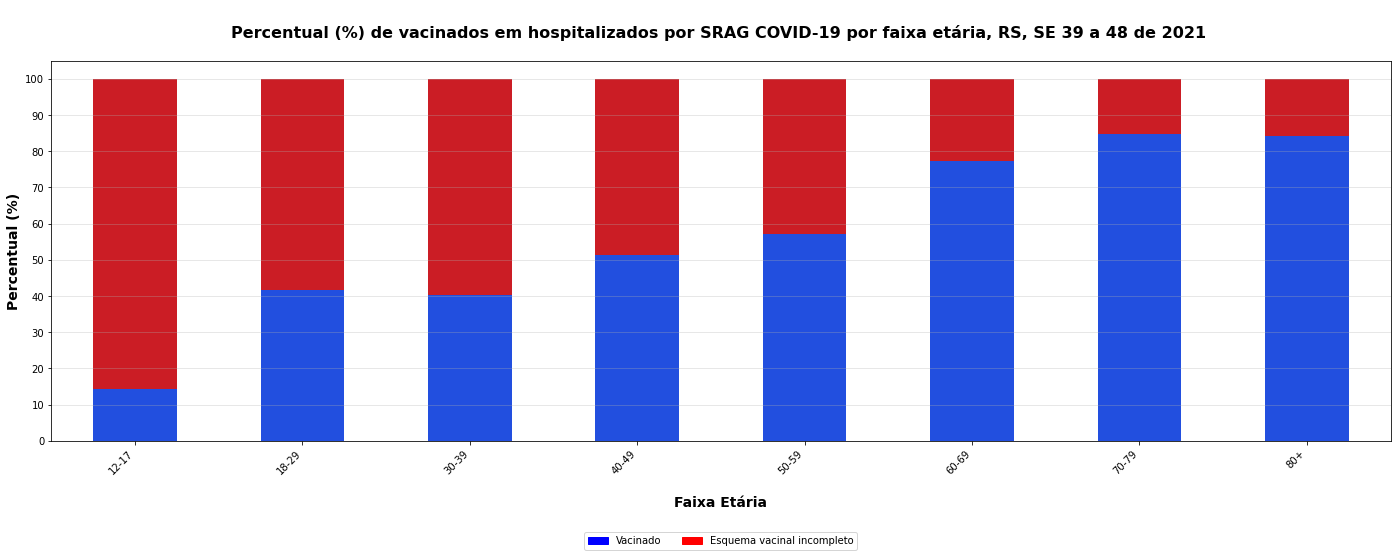

In [152]:
# GRAFICO ## HOSPITALIZADOS POR FAIXAS ETÁRIAS ##

df_faixas_grafico = df_faixas.loc[df_faixas['Faixa Etária'] != 'Total']
df_faixas_grafico['total'] = 100

fig, ax = plt.subplots(figsize=(24, 6))
colors = sns.color_palette("bright")
bar1 = sns.barplot(x="Faixa Etária",  y="total", data=df_faixas_grafico, color=colors[3])
bar2 = sns.barplot(x="Faixa Etária", y="% Vacinado", data=df_faixas_grafico, color=colors[0])

# add legend
top_bar = mpatches.Patch(color='red', label='Esquema vacinal incompleto')
bottom_bar = mpatches.Patch(color='blue', label='Vacinado')
plt.xticks(rotation=45, ha='right')
plt.legend(handles=[bottom_bar, top_bar], bbox_to_anchor=(0.5, -0.3), ncol=2, loc="lower center")
fig.subplots_adjust(bottom=0)
plt.title(f"\nPercentual (%) de vacinados em hospitalizados por SRAG COVID-19 por faixa etária, RS, SE {se_periodo} de 2021 \n",
         fontweight='bold', fontsize= 16)

plt.yticks(np.arange(0, 110, 10))
plt.grid(axis='y', linewidth=1, alpha=0.3)
change_width(ax, .5)

ax.set_xlabel('\nFaixa Etária', fontweight='bold', fontsize= 14)
ax.set_ylabel('Percentual (%)', fontweight='bold', fontsize= 14)

#plt.savefig(f'Graficos/Vacinados em hospitalizados por SRAG COVID-19 por faixa etária, RS, SE {se_periodo} de 2021.png', bbox_inches="tight")

plt.savefig(f'Grafico5 {se_periodo}.png', bbox_inches="tight")

plt.show()

In [153]:
#### FAIXAS ETARIAS x STATUS VACINAL x ÓBITOS #######
df_faixas_obitos = df_vacinados[['Idade', 'Faixa Etaria', 'Evolucao', 'SE', 'esquema_incompleto', 'vacinado']]

df_faixas_obitos['Idade'] = df_faixas_obitos['Idade'].astype(int)
df_faixas_obitos = df_faixas_obitos[df_faixas_obitos['Idade'] >= 12]
df_faixas_obitos.loc[((df_faixas_obitos['Idade'] >= 12) & (df_faixas_obitos['Idade'] <= 17)), 'Faixa Etaria'] = '12-17'
df_faixas_obitos.loc[((df_faixas_obitos['Idade'] >= 18) & (df_faixas_obitos['Idade'] <= 29)), 'Faixa Etaria'] = '18-29'
df_faixas_obitos['Faixa Etaria'] = df_faixas_obitos['Faixa Etaria'].str.replace(' anos', '')
df_faixas_obitos.loc[df_faixas_obitos['Faixa Etaria'].str.contains('80 e mais'), 'Faixa Etaria'] = '80+'
df_faixas_obitos.drop(columns=['Idade'], axis=1, inplace=True)

df_faixas_obitos = df_faixas_obitos[df_faixas_obitos['Evolucao'] == 'Óbito']
df_faixas_obitos['Óbitos'] = 1

df_faixas_obitos = df_faixas_obitos.pivot_table(values=['Óbitos', 'esquema_incompleto', 'vacinado'], index=['Faixa Etaria'], aggfunc='sum').reset_index()

# Insere linha com Total
df_faixas_obitos = df_faixas_obitos.append(df_faixas_obitos.sum(numeric_only=True), ignore_index=True).fillna('Total')

# Percentuais de vacinação entre os óbitos
df_faixas_obitos['%esquema_incompleto'] = ((df_faixas_obitos['esquema_incompleto'] / df_faixas_obitos['Óbitos'])*100).round(2)
df_faixas_obitos['%vacinado'] = ((df_faixas_obitos['vacinado'] / df_faixas_obitos['Óbitos'])*100).round(2)

cols = ['Óbitos', 'esquema_incompleto', 'vacinado']
df_faixas_obitos[cols] = df_faixas_obitos[cols].astype(int)

df_faixas_obitos.rename(columns={'Faixa Etaria': 'Faixa Etária', 'esquema_incompleto': 'Esquema vacinal incompleto', 'vacinado': 'Vacinado', '%esquema_incompleto': '% Esquema vacinal incompleto', '%vacinado': '% Vacinado'}, inplace=True)

df_faixas_obitos = df_faixas_obitos[['Faixa Etária', 'Óbitos', 'Esquema vacinal incompleto', 
                       '% Esquema vacinal incompleto', 'Vacinado','% Vacinado']]

#df_faixas_obitos.to_excel(f'Hospitalizados e obitos x esquema vacinal/Status vacinal x Óbitos por SRAG COVID-19 por faixa etária no RS SE {se_periodo} de 2021 gerado em {date_today}.xlsx', index=False)

df_faixas_obitos

,Faixa Etária,Óbitos,Esquema vacinal incompleto,% Esquema vacinal incompleto,Vacinado,% Vacinado
0,12-17,3,3,100.00,0,0.00
1,18-29,8,7,87.50,1,12.50
2,30-39,30,22,73.33,8,26.67
3,40-49,55,32,58.18,23,41.82
4,50-59,103,49,47.57,54,52.43
5,60-69,313,79,25.24,234,74.76
6,70-79,403,88,21.84,315,78.16
7,80+,295,46,15.59,249,84.41
8,Total,1210,326,26.94,884,73.06


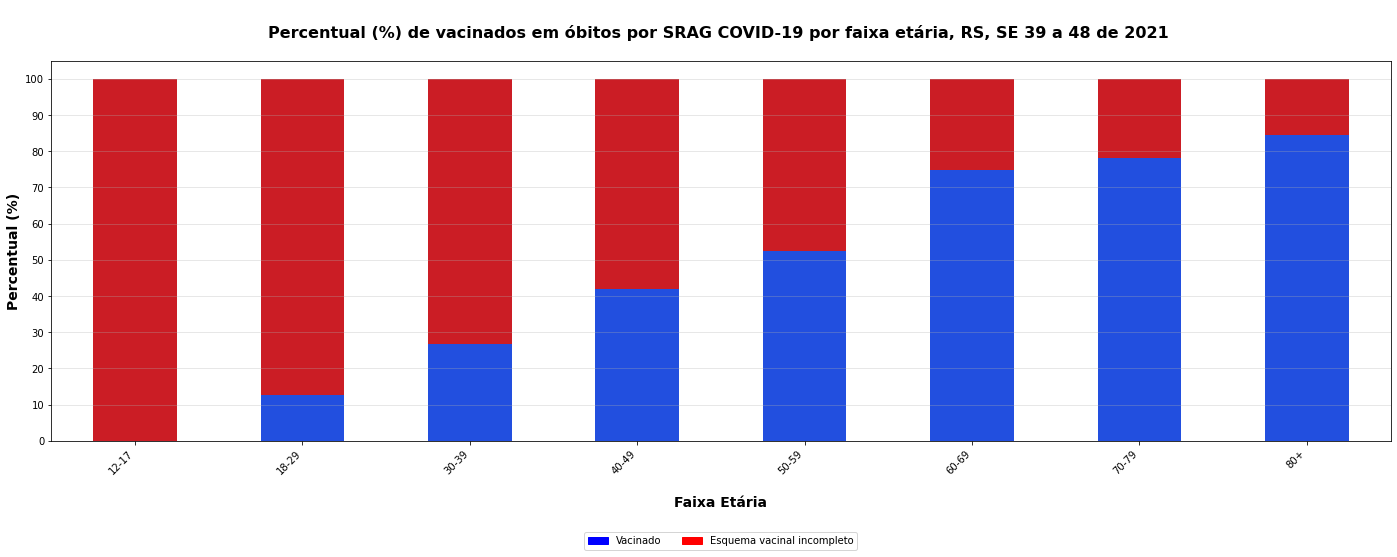

In [154]:
# GRAFICO ## ÓBITOS POR FAIXAS ETÁRIAS

df_faixas_obitos_grafico = df_faixas_obitos.loc[df_faixas_obitos['Faixa Etária'] != 'Total']
df_faixas_obitos_grafico['total'] = 100

fig, ax = plt.subplots(figsize=(24, 6))
colors = sns.color_palette("bright")
bar1 = sns.barplot(x="Faixa Etária",  y="total", data=df_faixas_obitos_grafico, color=colors[3])
bar2 = sns.barplot(x="Faixa Etária", y="% Vacinado", data=df_faixas_obitos_grafico, color=colors[0])

# add legend
top_bar = mpatches.Patch(color='red', label='Esquema vacinal incompleto')
bottom_bar = mpatches.Patch(color='blue', label='Vacinado')
plt.xticks(rotation=45, ha='right')
plt.legend(handles=[bottom_bar, top_bar], bbox_to_anchor=(0.5, -0.3), ncol=2, loc="lower center")
fig.subplots_adjust(bottom=0)
plt.title(f"\nPercentual (%) de vacinados em óbitos por SRAG COVID-19 por faixa etária, RS, SE {se_periodo} de 2021 \n",
         fontweight='bold', fontsize= 16)

plt.yticks(np.arange(0, 110, 10))
plt.grid(axis='y', linewidth=1, alpha=0.3)
change_width(ax, .5)

ax.set_xlabel('\nFaixa Etária', fontweight='bold', fontsize= 14)
ax.set_ylabel('Percentual (%)', fontweight='bold', fontsize= 14)

#plt.savefig(f'Graficos/Vacinados em óbitos por SRAG COVID-19 por faixa etária, RS, SE {se_periodo} de 2021.png', bbox_inches="tight")

plt.savefig(f'Grafico6 {se_periodo}.png', bbox_inches="tight")

plt.show()

In [155]:
"""dose de reforço
tabela:
só para 60 e mais
60-69
70-79
80+
incluir 3a categoria (com dose de reforço)
filtro pela coluna  'data_aplic_ref'
-não vacinado
-vacinado
-reforço
ver quando iniciou a dose de Reforço (SE)
"""

"dose de reforço\ntabela:\nsó para 60 e mais\n60-69\n70-79\n80+\nincluir 3a categoria (com dose de reforço)\nfiltro pela coluna  'data_aplic_ref'\n-não vacinado\n-vacinado\n-reforço\nver quando iniciou a dose de Reforço (SE)\n"

## ANÁLISE COM A DOSE DE REFORÇO

In [156]:
## APENAS PARA 60 E MAIS ANOS ##

df_ref = df_vacinados[['Data da Notificacao', 'Faixa Etaria', 'Idade', 'Evolucao', 'nm_regiao_covid',  
                       'v_dataaplicacao_dose_1', 'v_dataaplicacao_dose_2', 'v_dataaplicacao_dose_UNICA', 'data_aplic_ref']]

# Considera somente pessoas com 60 e mais anos:
df_ref['Idade'] = df_ref['Idade'].astype(int)
df_ref = df_ref[df_ref['Idade'] >= 60]

df_ref['Faixa Etaria'] = df_ref['Faixa Etaria'].str.replace(' anos', '')
df_ref.loc[df_ref['Faixa Etaria'].str.contains('80 e mais'), 'Faixa Etaria'] = '80+'
df_ref.drop(columns=['Idade'], axis=1, inplace=True)

# FILTROS Esquema incompleto X Vacinados X Dose de Reforço
# Filtro sem nenhuma dose + somente com D1
filtro_esq_incompleto = (df_ref['v_dataaplicacao_dose_2'].isna() & df_ref['v_dataaplicacao_dose_UNICA'].isna() & df_ref['data_aplic_ref'].isna())

# Filtro Esquema completo sem reforço (D2 | DU) - DRef
filtro_vacinado = (((df_ref['v_dataaplicacao_dose_2'].notna()) | df_ref['v_dataaplicacao_dose_UNICA'].notna()) & df_ref['data_aplic_ref'].isna())

# Filtro Esquema completo + dose de reforço (D1 + D2 | DU) + DRef
filtro_vac_reforco = df_ref['data_aplic_ref'].notna()

df_ref.loc[filtro_esq_incompleto, 'Esquema vacinal incompleto'] = 1 
df_ref.loc[filtro_vacinado, 'Vacinado'] = 1
df_ref.loc[filtro_vac_reforco, 'Vacinado com Reforço'] = 1


In [157]:
# Confere para ver se alguma está com marcação em 2 categorias
df_ref[df_ref['Esquema vacinal incompleto'].notna() & df_ref['Vacinado'].notna()]
df_ref[df_ref['Esquema vacinal incompleto'].notna() & df_ref['Vacinado com Reforço'].notna()]
df_ref[df_ref['Vacinado'].notna() & df_ref['Vacinado com Reforço'].notna()]

,Data da Notificacao,Faixa Etaria,Evolucao,nm_regiao_covid,v_dataaplicacao_dose_1,v_dataaplicacao_dose_2,v_dataaplicacao_dose_UNICA,data_aplic_ref,Esquema vacinal incompleto,Vacinado,Vacinado com Reforço


In [158]:
## HOSPITALIZADOS 60 e MAIS ANOS ## POR REGIÃO COVID
df_ref_hospit = df_ref.copy()

df_ref_hospit['Hospitalizados'] = 1

df_ref_hospit = df_ref_hospit.pivot_table(values=['Hospitalizados', 'Esquema vacinal incompleto', 'Vacinado', 'Vacinado com Reforço'], index=['nm_regiao_covid'], aggfunc='sum').reset_index()

df_ref_hospit = df_ref_hospit[['nm_regiao_covid', 'Hospitalizados', 'Esquema vacinal incompleto', 'Vacinado', 'Vacinado com Reforço']]
cols = ['Hospitalizados', 'Esquema vacinal incompleto', 'Vacinado', 'Vacinado com Reforço']
df_ref_hospit[cols] = df_ref_hospit[cols].astype(int)

# Insere linha com Total
df_ref_hospit = df_ref_hospit.append(df_ref_hospit.sum(numeric_only=True), ignore_index=True).fillna('Total')

# Percentuais de vacinação entre os hospitalizados
df_ref_hospit['% Esquema vacinal incompleto'] = ((df_ref_hospit['Esquema vacinal incompleto'] / df_ref_hospit['Hospitalizados'])*100).round(2)
df_ref_hospit['% Vacinado'] = ((df_ref_hospit['Vacinado'] / df_ref_hospit['Hospitalizados'])*100).round(2)
df_ref_hospit['% Vacinado com Reforço'] = ((df_ref_hospit['Vacinado com Reforço'] / df_ref_hospit['Hospitalizados'])*100).round(2)

df_ref_hospit.rename(columns={'nm_regiao_covid': 'Região Covid'}, inplace=True)
df_ref_hospit = df_ref_hospit[['Região Covid', 'Hospitalizados', 'Esquema vacinal incompleto', '% Esquema vacinal incompleto', 
                               'Vacinado', '% Vacinado', 'Vacinado com Reforço', '% Vacinado com Reforço']]
df_ref_hospit

,Região Covid,Hospitalizados,Esquema vacinal incompleto,% Esquema vacinal incompleto,Vacinado,% Vacinado,Vacinado com Reforço,% Vacinado com Reforço
0,BAGE - R22,40.0,7.0,17.50,31.0,77.50,2.0,5.00
1,CACHOEIRA DO SUL - R27,28.0,3.0,10.71,21.0,75.00,4.0,14.29
2,CANOAS - R08,184.0,30.0,16.30,126.0,68.48,28.0,15.22
3,CAPAO DA CANOA - R04 R05,152.0,30.0,19.74,97.0,63.82,25.0,16.45
4,CAXIAS DO SUL - R23 R24 R25 R26,460.0,85.0,18.48,289.0,62.83,86.0,18.70
5,CRUZ ALTA - R12,29.0,4.0,13.79,21.0,72.41,4.0,13.79
6,ERECHIM - R16,32.0,7.0,21.88,16.0,50.00,9.0,28.12
7,GUAIBA - R09,74.0,10.0,13.51,43.0,58.11,21.0,28.38
8,IJUI - R13,86.0,17.0,19.77,56.0,65.12,13.0,15.12
9,LAJEADO - R29 R30,78.0,10.0,12.82,43.0,55.13,25.0,32.05


In [159]:
df_ref_hospit_grafico = df_ref_hospit.copy()
# Soma os vacinados + vacinados com reforço para plotar certo no gráfico
df_ref_hospit_grafico['Vacinado'] = df_ref_hospit_grafico['Vacinado'] + df_ref_hospit_grafico['Vacinado com Reforço']
df_ref_hospit_grafico['% Vacinado'] = df_ref_hospit_grafico['% Vacinado'] + df_ref_hospit_grafico['% Vacinado com Reforço']

#df_ref_hospit_grafico.to_excel(f'Hospitalizados e obitos x esquema vacinal/Hospitalizados por SRAG COVID-19 60mais anos x vacinação com reforço por região covid {date_today}.xlsx', index=False)
df_ref_hospit_grafico

,Região Covid,Hospitalizados,Esquema vacinal incompleto,% Esquema vacinal incompleto,Vacinado,% Vacinado,Vacinado com Reforço,% Vacinado com Reforço
0,BAGE - R22,40.0,7.0,17.50,33.0,82.50,2.0,5.00
1,CACHOEIRA DO SUL - R27,28.0,3.0,10.71,25.0,89.29,4.0,14.29
2,CANOAS - R08,184.0,30.0,16.30,154.0,83.70,28.0,15.22
3,CAPAO DA CANOA - R04 R05,152.0,30.0,19.74,122.0,80.27,25.0,16.45
4,CAXIAS DO SUL - R23 R24 R25 R26,460.0,85.0,18.48,375.0,81.53,86.0,18.70
5,CRUZ ALTA - R12,29.0,4.0,13.79,25.0,86.20,4.0,13.79
6,ERECHIM - R16,32.0,7.0,21.88,25.0,78.12,9.0,28.12
7,GUAIBA - R09,74.0,10.0,13.51,64.0,86.49,21.0,28.38
8,IJUI - R13,86.0,17.0,19.77,69.0,80.24,13.0,15.12
9,LAJEADO - R29 R30,78.0,10.0,12.82,68.0,87.18,25.0,32.05


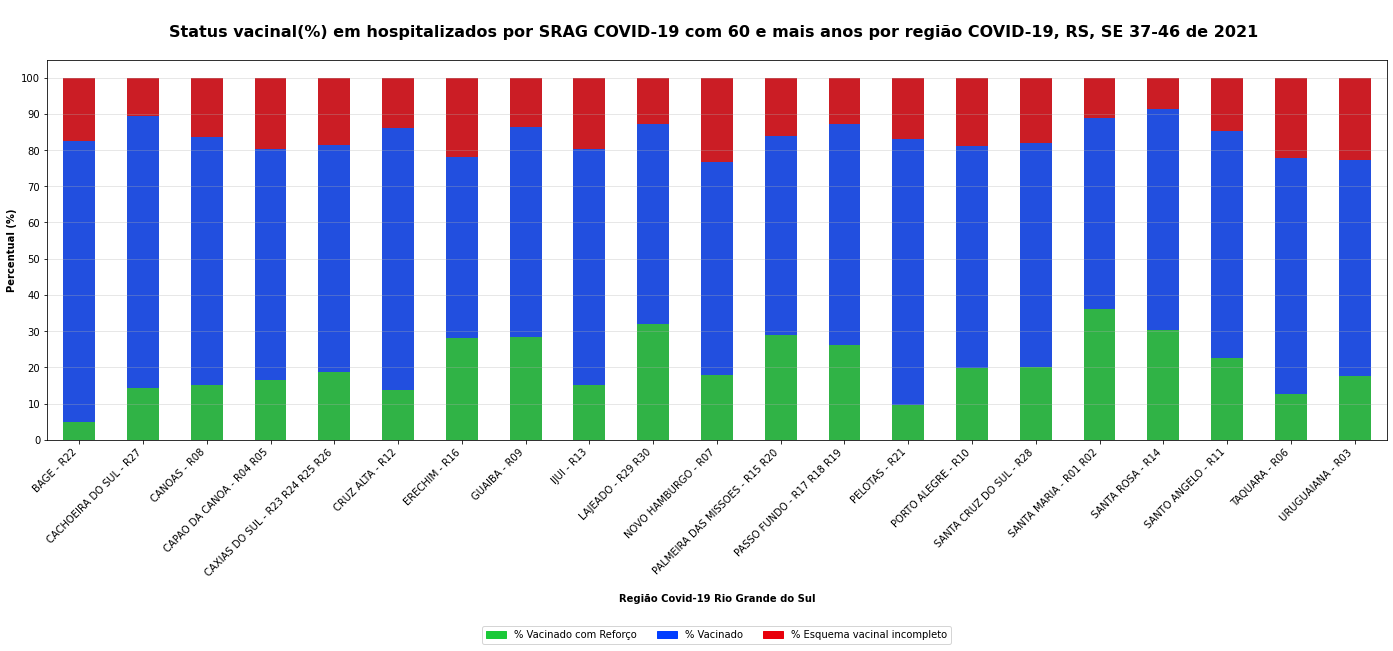

In [160]:
# Grafico ## HOSPITALIZADOS 60 e MAIS ANOS ## POR REGIÃO COVID
        
df_ref_hospit_grafico = df_ref_hospit_grafico.loc[df_ref_hospit_grafico['Região Covid'] != 'Total']
df_ref_hospit_grafico['total'] = 100

fig, ax = plt.subplots(figsize=(24, 6))
colors = sns.color_palette("bright")
bar1 = sns.barplot(x="Região Covid",  y="total", data=df_ref_hospit_grafico, color=colors[3])
bar2 = sns.barplot(x="Região Covid", y="% Vacinado", data=df_ref_hospit_grafico, color=colors[0])
bar3 = sns.barplot(x="Região Covid", y="% Vacinado com Reforço", data=df_ref_hospit_grafico, color=colors[2])

# add legend
top_bar = mpatches.Patch(color=colors[3], label='% Esquema vacinal incompleto')
bottom_bar = mpatches.Patch(color=colors[0], label='% Vacinado')
ref_bar = mpatches.Patch(color=colors[2], label='% Vacinado com Reforço')
plt.xticks(rotation=45, ha='right')
plt.legend(handles=[ref_bar, bottom_bar, top_bar], bbox_to_anchor=(0.5, -0.55), ncol=3, loc="lower center")
fig.subplots_adjust(bottom=0)
plt.title("\nStatus vacinal(%) em hospitalizados por SRAG COVID-19 com 60 e mais anos por região COVID-19, RS, SE 37-46 de 2021 \n",
         fontweight='bold', fontsize= 16)

plt.yticks(np.arange(0, 110, 10))
plt.grid(axis='y', linewidth=1, alpha=0.3)
change_width(ax, .5)

ax.set_xlabel('\nRegião Covid-19 Rio Grande do Sul', fontweight='bold')
ax.set_ylabel('Percentual (%)', fontweight='bold')

#plt.savefig(f'Graficos/Status vacinal(%) em hospitalizados por SRAG COVID-19 com 60 e mais anos por região COVID-19, RS, SE {se_periodo} de 2021 {date_today}.png', bbox_inches="tight")

plt.savefig(f'Grafico7 {se_periodo}.png', bbox_inches="tight")

plt.show()

In [161]:
colors

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [162]:
## ÓBITOS 60 e MAIS ANOS ## POR REGIÃO COVID
df_ref_obitos = df_ref.copy()
df_ref_obitos = df_ref_obitos[df_ref_obitos['Evolucao'] == 'Óbito']

df_ref_obitos['Óbitos'] = 1

df_ref_obitos = df_ref_obitos.pivot_table(values=['Óbitos', 'Esquema vacinal incompleto', 'Vacinado', 'Vacinado com Reforço'], index=['nm_regiao_covid'], aggfunc='sum').reset_index()

df_ref_obitos = df_ref_obitos[['nm_regiao_covid', 'Óbitos', 'Esquema vacinal incompleto', 'Vacinado', 'Vacinado com Reforço']]
cols = ['Óbitos', 'Esquema vacinal incompleto', 'Vacinado', 'Vacinado com Reforço']
df_ref_obitos[cols] = df_ref_obitos[cols].astype(int)

# Insere linha com Total
df_ref_obitos = df_ref_obitos.append(df_ref_obitos.sum(numeric_only=True), ignore_index=True).fillna('Total')

# Percentuais de vacinação entre os Óbitos
df_ref_obitos['% Esquema vacinal incompleto'] = ((df_ref_obitos['Esquema vacinal incompleto'] / df_ref_obitos['Óbitos'])*100).round(2)
df_ref_obitos['% Vacinado'] = ((df_ref_obitos['Vacinado'] / df_ref_obitos['Óbitos'])*100).round(2)
df_ref_obitos['% Vacinado com Reforço'] = ((df_ref_obitos['Vacinado com Reforço'] / df_ref_obitos['Óbitos'])*100).round(2)

df_ref_obitos.rename(columns={'nm_regiao_covid': 'Região Covid'}, inplace=True)
df_ref_obitos = df_ref_obitos[['Região Covid', 'Óbitos', 'Esquema vacinal incompleto', '% Esquema vacinal incompleto', 
                               'Vacinado', '% Vacinado', 'Vacinado com Reforço', '% Vacinado com Reforço']]
df_ref_obitos

,Região Covid,Óbitos,Esquema vacinal incompleto,% Esquema vacinal incompleto,Vacinado,% Vacinado,Vacinado com Reforço,% Vacinado com Reforço
0,BAGE - R22,9.0,4.0,44.44,5.0,55.56,0.0,0.00
1,CACHOEIRA DO SUL - R27,13.0,2.0,15.38,10.0,76.92,1.0,7.69
2,CANOAS - R08,88.0,17.0,19.32,63.0,71.59,8.0,9.09
3,CAPAO DA CANOA - R04 R05,52.0,12.0,23.08,39.0,75.00,1.0,1.92
4,CAXIAS DO SUL - R23 R24 R25 R26,126.0,28.0,22.22,91.0,72.22,7.0,5.56
5,CRUZ ALTA - R12,19.0,1.0,5.26,15.0,78.95,3.0,15.79
6,ERECHIM - R16,4.0,3.0,75.00,1.0,25.00,0.0,0.00
7,GUAIBA - R09,30.0,5.0,16.67,24.0,80.00,1.0,3.33
8,IJUI - R13,19.0,3.0,15.79,15.0,78.95,1.0,5.26
9,LAJEADO - R29 R30,23.0,4.0,17.39,17.0,73.91,2.0,8.70


In [163]:
df_ref_obitos_grafico = df_ref_obitos.copy()
# Soma os vacinados + vacinados com reforço para plotar certo no gráfico
df_ref_obitos_grafico['Vacinado'] = df_ref_obitos_grafico['Vacinado'] + df_ref_obitos_grafico['Vacinado com Reforço']
df_ref_obitos_grafico['% Vacinado'] = df_ref_obitos_grafico['% Vacinado'] + df_ref_obitos_grafico['% Vacinado com Reforço']
#df_ref_obitos_grafico.to_excel(f'Hospitalizados e obitos x esquema vacinal/Óbitos por SRAG COVID-19 60mais anos x vacinação com reforço por região covid, SE {se_periodo} de 2021 gerado em {date_today}.xlsx', index=False)
df_ref_obitos_grafico

,Região Covid,Óbitos,Esquema vacinal incompleto,% Esquema vacinal incompleto,Vacinado,% Vacinado,Vacinado com Reforço,% Vacinado com Reforço
0,BAGE - R22,9.0,4.0,44.44,5.0,55.56,0.0,0.00
1,CACHOEIRA DO SUL - R27,13.0,2.0,15.38,11.0,84.61,1.0,7.69
2,CANOAS - R08,88.0,17.0,19.32,71.0,80.68,8.0,9.09
3,CAPAO DA CANOA - R04 R05,52.0,12.0,23.08,40.0,76.92,1.0,1.92
4,CAXIAS DO SUL - R23 R24 R25 R26,126.0,28.0,22.22,98.0,77.78,7.0,5.56
5,CRUZ ALTA - R12,19.0,1.0,5.26,18.0,94.74,3.0,15.79
6,ERECHIM - R16,4.0,3.0,75.00,1.0,25.00,0.0,0.00
7,GUAIBA - R09,30.0,5.0,16.67,25.0,83.33,1.0,3.33
8,IJUI - R13,19.0,3.0,15.79,16.0,84.21,1.0,5.26
9,LAJEADO - R29 R30,23.0,4.0,17.39,19.0,82.61,2.0,8.70


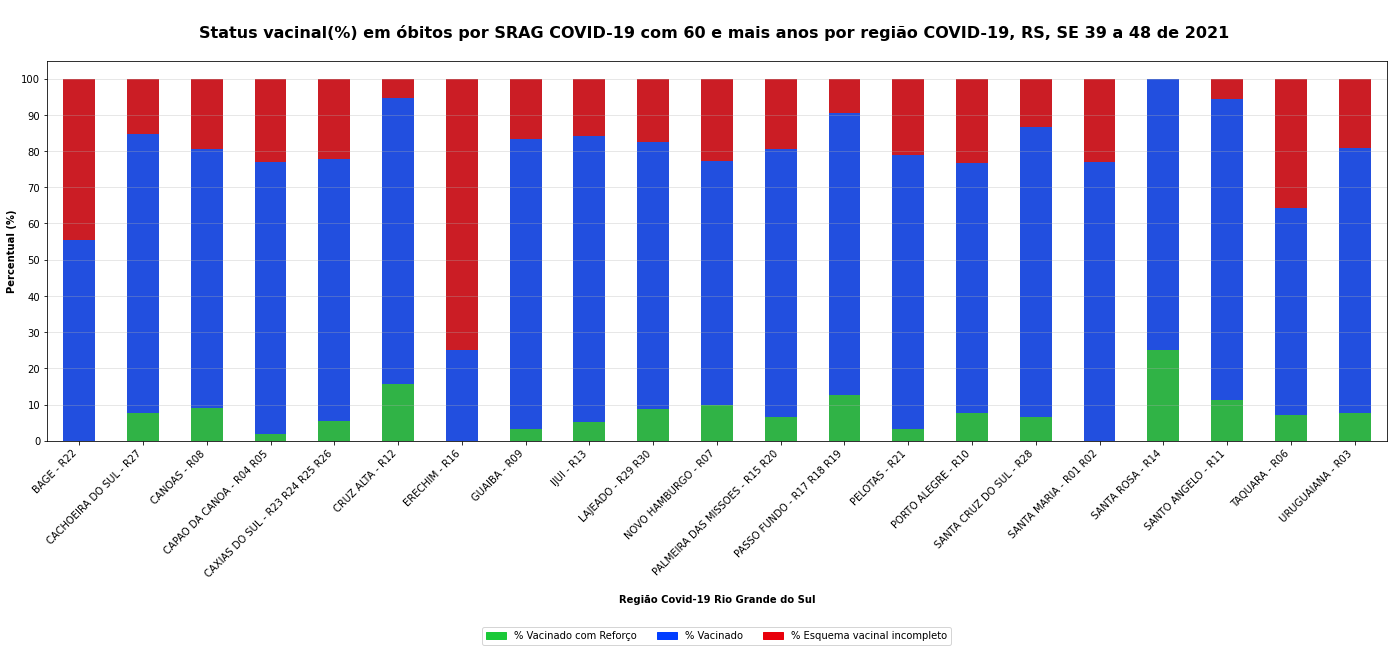

In [164]:
# Grafico ## ÓBITOS 60 e MAIS ANOS ## POR REGIÃO COVID

df_ref_obitos_grafico = df_ref_obitos_grafico.loc[df_ref_obitos_grafico['Região Covid'] != 'Total']
df_ref_obitos_grafico['total'] = 100

fig, ax = plt.subplots(figsize=(24, 6))
colors = sns.color_palette("bright")
bar1 = sns.barplot(x="Região Covid",  y="total", data=df_ref_obitos_grafico, color=colors[3])
bar2 = sns.barplot(x="Região Covid", y="% Vacinado", data=df_ref_obitos_grafico, color=colors[0])
bar3 = sns.barplot(x="Região Covid", y="% Vacinado com Reforço", data=df_ref_obitos_grafico, color=colors[2])

# add legend
top_bar = mpatches.Patch(color=colors[3], label='% Esquema vacinal incompleto')
bottom_bar = mpatches.Patch(color=colors[0], label='% Vacinado')
ref_bar = mpatches.Patch(color=colors[2], label='% Vacinado com Reforço')
plt.xticks(rotation=45, ha='right')
plt.legend(handles=[ref_bar, bottom_bar, top_bar], bbox_to_anchor=(0.5, -0.55), ncol=3, loc="lower center")
fig.subplots_adjust(bottom=0)
plt.title(f"\nStatus vacinal(%) em óbitos por SRAG COVID-19 com 60 e mais anos por região COVID-19, RS, SE {se_periodo} de 2021 \n",
         fontweight='bold', fontsize= 16)

plt.yticks(np.arange(0, 110, 10))
plt.grid(axis='y', linewidth=1, alpha=0.3)
change_width(ax, .5)

ax.set_xlabel('\nRegião Covid-19 Rio Grande do Sul', fontweight='bold')
ax.set_ylabel('Percentual (%)', fontweight='bold')

#plt.savefig(f'Graficos/Status vacinal(%) em óbitos por SRAG COVID-19 com 60 e mais anos por região COVID-19, RS, SE {se_periodo} de 2021 gerado em {date_today}.png', bbox_inches="tight")

plt.savefig(f'Grafico8 {se_periodo}.png', bbox_inches="tight")

plt.show()

## Write Report in .docx

In [179]:
from docx import Document
from docx.shared import Inches

from docx.enum.style import WD_STYLE_TYPE
from docx.enum.table import WD_TABLE_ALIGNMENT
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.enum.section import WD_ORIENT
from docx.enum.section import WD_SECTION
from docx.shared import Pt
from docx.shared import Inches
import seaborn as sns
from datetime import date
data_hoje = date.today().strftime('%d/%m/%Y')

document = Document('../template.docx')

# Orientação da página - Paisagem
section = document.sections[-1]
section.orientation = WD_ORIENT.LANDSCAPE
new_width, new_height = section.page_height, section.page_width
section.page_width = new_width
section.page_height = new_height

styles = document.styles
#estilo do paragrafo
p = styles.add_style('Paragraph1', WD_STYLE_TYPE.PARAGRAPH)
p.font.name = 'Calibri'
p.font.size = Pt(14)

p = styles.add_style('Paragraph2', WD_STYLE_TYPE.PARAGRAPH)
p.font.name = 'Calibri'
p.font.size = Pt(18)

p = styles.add_style('Paragraph3', WD_STYLE_TYPE.PARAGRAPH)
p.font.name = 'Calibri'
p.font.size = Pt(11)

p = styles.add_style('Paragraph4', WD_STYLE_TYPE.PARAGRAPH)
p.font.name = 'Calibri'
p.font.size = Pt(10)


#estilo do paragrafo
p = styles.add_style('Table', WD_STYLE_TYPE.TABLE)
p.font.name = 'Light Shading'
p.font.size = Pt(10)

#texto
p1 = document.add_paragraph('SES/RS SECRETARIA DA SAÚDE DO ESTADO DO RIO GRANDE DO SUL\nCEVS – CENTRO ESTADUAL DE VIGILÂNCIA EM SAÚDE\nDivisão de Vigilância Epidemiológica', style='Paragraph1')
p1.alignment = WD_ALIGN_PARAGRAPH.CENTER

p2 = document.add_paragraph(f'\n\n\n\nPercentual de vacinados em hospitalizados e óbitos por SRAG COVID-19, RS\nSemanas Epidemiológicas {se_periodo} / 2021\nTABELAS E GRÁFICOS\n\n\n', style='Paragraph2')
p2.alignment = WD_ALIGN_PARAGRAPH.CENTER

p3 = document.add_paragraph(f'Elaboração: Paola Lucca Pizutti e Natanael de Campos Klein', style='Paragraph1')
p3.alignment = WD_ALIGN_PARAGRAPH.CENTER

p4 = document.add_paragraph(f'\n\n\nPorto Alegre, RS, {data_hoje}', style='Paragraph3')
p4.alignment = WD_ALIGN_PARAGRAPH.CENTER

#nova página
document.add_page_break()

infos = [
    {
        'df': df_60anos_mais,
        'graph': f'Grafico1 {se_periodo}.png',
        'title': f'Percentual de vacinados em hospitalizados por SRAG COVID-19 com 60 e mais anos por região covid, RS, {se_periodo}, 2021'
    },
    {
        'df': df_18_a_59_anos,
        'graph': f'Grafico2 {se_periodo}.png',
        'title': f'Percentual de vacinados em hospitalizados por SRAG COVID-19 com 18 a 59 anos por região covid, RS, {se_periodo}, 2021'
    },
    {
        'df': obitos_60anos_mais,
        'graph': f'Grafico3 {se_periodo}.png',
        'title': f'Percentual de vacinados em óbitos por SRAG COVID-19 com 60 e mais anos por região covid, RS, {se_periodo}, 2021'
    },
    {
        'df': obito_18_a_59_anos,
        'graph': f'Grafico4 {se_periodo}.png',
        'title': f'Percentual de vacinados em óbitos por SRAG COVID-19 com 18 a 59 anos por região covid, RS, {se_periodo}, 2021'
    },
    {
        'df': df_faixas,
        'graph': f'Grafico5 {se_periodo}.png',
        'title': f'Percentual de vacinados em hospitalizados por SRAG COVID-19 por faixa etária, RS, {se_periodo}, 2021'
    },
    {
        'df': df_faixas_obitos,
        'graph': f'Grafico6 {se_periodo}.png',
        'title': f'Percentual de vacinados em óbitos por SRAG COVID-19 por faixa etária, RS, {se_periodo}, 2021'
    },
    {
        'df': df_ref_hospit,
        'graph': f'Grafico7 {se_periodo}.png',
        'title': f'Status vacinal (%) em hospitalizados por SRAG COVID-19 com 60 e mais anos por região covid, RS, {se_periodo}, 2021'
    },
    {
        'df': df_ref_obitos,
        'graph': f'Grafico8 {se_periodo}.png',
        'title': f'Status vacinal (%) em óbitos por SRAG COVID-19 com 60 e mais anos por região covid, RS, {se_periodo}, 2021'
    }
]

# Função que cria as tabelas
def create_table(document, df):
    # add a table to the end and create a reference variable
    # extra row is so we can add the header row
    t = document.add_table(df.shape[0]+1, df.shape[1], style='epidemio2')

    # add the header rows.
    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]

    # add the rest of the data frame
    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])

    for cell in t.columns[0].cells:
        cell.width = Inches(2.5)

# Lista de dataframes para criar as tabelas:


import locale
import time
locale.setlocale(locale.LC_ALL, "pt_br")
date_fmt = time.strftime("%d %B de %Y")

font_text = f'Fonte: Banco Sivep Exportação, {date_fmt}'


for info in infos:
    title_p = document.add_paragraph(info['title'], style='Paragraph3')
    title_p.alignment = WD_ALIGN_PARAGRAPH.CENTER
    create_table(document, info['df'])
    font_p = document.add_paragraph(font_text, style='Paragraph4')
    font_p.alignment = WD_ALIGN_PARAGRAPH.CENTER
    document.add_page_break()
    document.add_picture(info['graph'], width=Inches(9.5))
    document.add_page_break()


# Salva em um arquivo docx
document.save(f'Relatório hospitalizados e óbitos por SRAG COVID19 x Status vacinal SE {se_periodo} de 2021.docx')